<a href="https://colab.research.google.com/github/YKochura/rl-kpi/blob/main/practice/pr3_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вступ

Deep Q-Network (DQN) представлено компанією DeepMind у 2013 році, значно розширило можливості алгоритмів навчання з підкріпленням, дозволивши ефективно апроксимувати Q-функцію у високорозмірних просторах станів за допомогою глибоких нейронних мереж.

## Мета практичної роботи:

- Дослідити середовище `LunarLander-v3` та поведінку ненавченого агента.
- Налаштувати **Gymnasium**.
- Реалізувати та навчити DQN з нуля.
- Продемонструвати поведінку навченого агента.

# Налаштування

Спочатку встановіть необхідні пакети. Якщо ви використовуєте Colab, все повинно працювати без проблем. Однак на локальній системі можуть виникнути деякі проблеми з установкою залежностей.

In [2]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399000 sha256=bdd06ac732422408d231cb3e2820afb318bbecaf129c6af4cbb5fb18cf9680c5
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import io
import base64
import imageio.v2 as imageio

# Середовище

У середовищі `Lunar Lander` агент отримує 8-вимірний вектор стану, що включає положення (x, y), швидкості, кут нахилу, кутову швидкість і контакт з поверхнею. Простір дій дискретний і включає 4 варіанти: нічого не робити, запуск лівого двигуна, запуск основного двигуна, запуск правого двигуна. Завдання агента — розробити стратегію, яка мінімізує швидкість посадки, витрату пального та ризик аварії.

Давайте ініціалізуємо середовище `LunarLander-v3`, виконаємо випадкові дії та переглянемо запис цього процесу.

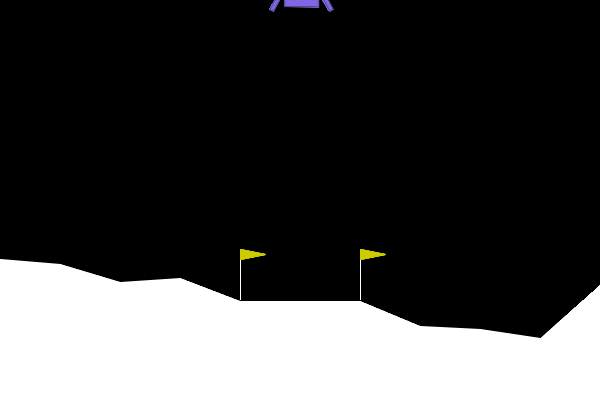

In [4]:
# Створюємо середовище
env = gym.make(
    "LunarLander-v3",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode="rgb_array" #None  # або "rgb_array", якщо потрібно відобразити кадри
)

# Ініціалізуємо
obs, info = env.reset(seed=42)
frames = []  # сюди будемо зберігати кадри

done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    done = terminated or truncated

env.close()

# Збережемо як GIF для перегляду
imageio.mimsave('/tmp/lunarlander.gif', frames, fps=30, loop=0)

# Показ у ноутбуці
from IPython.display import Image
Image(filename='/tmp/lunarlander.gif')

In [5]:
print(f"Простір спостережень: {env.observation_space}")

Простір спостережень: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [6]:
print(f"Простір дій: {env.action_space}")

Простір дій: Discrete(4)


[](https://i.imgur.com/tQ3zeQA.gif)

## Загальна інформація
Ця інформація взята з офіційної документації **Gymnasium**.

https://gymnasium.farama.org/environments/box2d/lunar_lander/

| Feature Category  | Details                                |
|-------------------|----------------------------------------|
| Action Space      | Discrete(4)                            |
| Observation Shape | (8,)                                   |
| Observation High  | [ 2.5 2.5 10. 10. 6.2831855 10. 1. 1.  ]         |
| Observation Low   | [ -2.5 -2.5 -10. -10. -6.2831855 -10. -0. -0.  ] |
| Import            | `gymnasium.make("LunarLander-v3")`           |

Це середовище є класичною задачею оптимізації траєкторії ракети.

Існують дві версії середовища: дискретне та неперервне. Посадкова площадка завжди знаходиться в координатах (0,0). Координати посадкової площадки — це перші два числа у векторі стану. Можлива посадка поза межами площадки. Паливо в середовищі необмежене, тому агент може навчитися літати й здійснити посадку вже з першої спроби.

## Простір дій

| Action  | Result                          |
|---------|---------------------------------|
| 0       | Do nothing                      |
| 1       | Fire left orientation engine    |
| 2       | Fire main engine                |
| 3       | Fire right orientation engine   |

## Простір спостережень
Стан представлений 8-вимірним вектором: координати модуля в `x` та `y`, лінійні швидкості по `x` та `y`, кут нахилу, кутова швидкість, а також два булеві значення, що показують, чи кожна нога контактує з поверхнею.

| Observation  | Value                                   |
|--------------|-----------------------------------------|
| 0            | `x` координата (float)                  |
| 1            | `y` координата (float)                  |
| 2            | `x` лінійна швидкість (float)             |
| 3            | `y` лінійна швидкість (float)             |
| 4            | Кут у радіанах від -2π до +2π (float)  |
| 5            | Кутова швидкість (float)                |
| 6            | Контакт лівою ногою (bool)                 |
| 7            | Контакт правою ногою (bool)                |


## Винагороди

Після кожного кроку агент отримує винагороду. Загальна винагорода епізоду — це сума винагород за всі кроки протягом цього епізоду.

Для кожного кроку винагорода:
- збільшується або зменшується в залежності від того, наскільки близько або далеко модуль знаходиться від посадкової площадки;
- збільшується або зменшується залежно від того, наскільки повільно або швидко рухається модуль;
- зменшується, якщо модуль нахилений (кут не горизонтальний);
- збільшується на 10 балів за кожну ногу, що контактує з поверхнею;
- зменшується на 0.03 бали за кадр, якщо працює бічний двигун;
- зменшується на 0.3 бали за кадр, якщо працює основний двигун.

Епізод отримує додаткову винагороду: -100 балів за аварію або +100 балів за успішну посадку.

Епізод вважається вирішеним, якщо сумарна винагорода досягає щонайменше 200 балів.

## Початковий стан
Модуль починає у верхній центральній частині вікна з випадково заданою початковою силою, застосованою до його центру мас.

## Завершення епізоду

Епізод закінчується, якщо:

- Модуль розбивається (тіло модуля контактує з поверхнею Місяця);
- Модуль виходить за межі вікна відображення (координата x > 2.5);
- Модуль неактивний. Згідно з документацією Box2D, тіло, яке неактивне, не рухається і не взаємодіє з іншими тілами.

---

# Глибоке навчання з підкріпленням

Щоб вирішити це завдання, ми використаємо методи глибокого навчання з підкріпленням, щоб навчити агента садити космічний модуль.

Прості табличні методи обмежені дискретними просторами спостережень, тобто кількість можливих станів обмежена. У `LunarLander-v3` ми маємо неперервний простір станів з 8 параметрів, що фактично дає майже нескінченну кількість можливих станів. Можна спробувати об’єднувати схожі значення в групи (бінування), але через чутливе управління модулем навіть незначні помилки можуть призвести до серйозних відхилень.

Щоб обійти цю проблему, ми використаємо **нейронну мережу для апроксимації Q-функції**. Це дозволяє передбачати оптимальні дії для будь-якого стану навіть у випадку величезної кількості потенційних станів. Такий підхід набагато краще підходить для нашої задачі.

## Алгоритм DQN

Цей проривний алгоритм був використаний у 2015 році, щоб досягти рівня продуктивності людини у кількох іграх для Atari 2600.

Оригінальну статтю, опубліковану в Nature, можна переглянути тут: https://www.nature.com/articles/nature14236

# Алгоритм DQN

1. **Ініціалізація**
   - Ініціалізуйте параметри двох нейронних мереж: $Q(s,a)$ (онлайн-мережа) та $\hat{Q}(s,a)$ (цільова мережа) з випадковими вагами.
   - Обидві мережі відображають пару стан-дія у Q-значення.
   - Встановіть ймовірність дослідження $ε = 1.0$.
   - Створіть порожний **replay buffer**.

2. **Вибір дії**
   - Використовуйте **epsilon-greedy стратегію**.
   - З ймовірністю $ε$ оберіть випадкову дію $a$.
   - Інакше оберіть дію, яка максимізує Q-значення:  $a = argmax_a Q(s,a)$

3. **Збір досвіду**
   - Виконайте дію $a$ у середовищі.
   - Спостерігайте винагороду `r` та наступний стан `s'`.

4. **Збереження досвіду**
   - Збережіть перехід $(s,a,r,s')$ у replay buffer.

5. **Вибірка**
   - Випадково оберіть **mini-batch** переходів для навчання онлайн-мережі.

6. **Обчислення цільового значення**
   - Для кожного переходу у mini-batch обчисліть $y$:
     - Якщо епізод завершився: $y = r$
     - Інакше:  $y = r + \gamma \max_{a' \in A} \hat{Q}(s', a')$

7. **Обчислення втрат**
   - Втрати:  $\mathcal{L} = (Q(s,a) - y)^2$

8. **Оновлення онлайн-мережі**
   - Використовуйте **SGD** для мінімізації втрат.

9. **Оновлення цільової мережі**
   - Кожні `N` кроків копіюйте ваги онлайн-мережі у цільову мережу $\hat{Q}(s,a)$.

10. **Повторення**
    - Поверніться до кроку 2 і повторюйте до збіжності.

## Визначення DQN

Ми використовуємо багатошаровий перцептрон (MLP), який приймає на вхід стан агента та видає Q-значення для всіх можливих дій. Для середовища `LunarLander-v3` стан представлений 8-вимірним вектором, а кількість дій дорівнює 4.

In [8]:
import torch

class DQN(torch.nn.Module):
    '''
    This class defines a deep Q-network (DQN), a type of artificial neural network used in reinforcement learning.
    The DQN is used to estimate the Q-values, which represent the expected return for each action in each state.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        '''
        Initialize a network with the following architecture:
            Input layer (state_size, hidden_size)
            Hidden layer 1 (hidden_size, hidden_size)
            Output layer (hidden_size, action_size)
        '''
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        '''
        Define the forward pass of the DQN. This function is called when the network is called to estimate Q-values.

        Parameters
        ----------
        state: torch.Tensor
            The state for which to estimate the Q-values.

        Returns
        -------
        torch.Tensor
            The estimated Q-values for each action in the input state.
        '''
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

# Replay Buffer

У контексті RL ми використовуємо структуру даних, відому як `replay buffer`, яка реалізована на основі `deque`. `Replay buffer` зберігає та вибірково надає досвід агента, що допомагає подолати проблему кореляції кроків під час навчання.

Deque (двостороння черга) — це структура даних, яка дозволяє додавати або видаляти елементи з обох кінців. Вона особливо корисна, коли потрібні швидкі операції додавання або видалення на початку або в кінці контейнера з O(1) складністю, на відміну від списку (list), де ці операції мають складність O(n).

`Deque` також дозволяє встановлювати максимальний розмір. Якщо під час вставки (push) розмір перевищено, елемент з протилежного кінця автоматично видаляється, зберігаючи максимальну довжину.

У `replay buffer` метод `push` використовується для додавання нового досвіду. Якщо додавання перевищує максимальний розмір буфера, найстаріший досвід автоматично видаляється. Це гарантує, що буфер завжди буде містити найсвіжіший досвід до межі своєї ємності.

Метод `sample` використовується для вибірки випадкового міні-батчу досвідів з буфера. Така випадкова вибірка критично важлива для розриву кореляцій у послідовності досвідів, що забезпечує більш стабільне та ефективне навчання.

Поєднання свіжого досвіду та випадковості дозволяє навчатись на нових даних без сильно корельованих тренувальних зразків.


In [11]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    '''
    This class represents a replay buffer, a type of data structure commonly used in reinforcement learning algorithms.
    The buffer stores past experiences in the environment, allowing the agent to sample and learn from them at later times.
    This helps to break the correlation of sequential observations and stabilize the learning process.

    Parameters
    ----------
    buffer_size: int, default=10000
        The maximum number of experiences that can be stored in the buffer.
    '''
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        '''
        Add a new experience to the buffer. Each experience is a tuple containing a state, action, reward,
        the resulting next state, and a done flag indicating whether the episode has ended.

        Parameters
        ----------
        state: array-like
            The state of the environment before taking the action.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        '''
        Randomly sample a batch of experiences from the buffer. The batch size must be smaller or equal to the current number of experiences in the buffer.

        Parameters
        ----------
        batch_size: int
            The number of experiences to sample from the buffer.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing arrays of states, actions, rewards, next states, and done flags.
        '''
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        '''
        Get the current number of experiences in the buffer.

        Returns
        -------
        int
            The number of experiences in the buffer.
        '''
        return len(self.buffer)

## Агент DQN

Агент DQN відповідає за взаємодію зі середовищем: обирає дії, збирає досвід, зберігає його у **replay buffer** і використовує цей досвід для навчання мережі. Розглянемо кожну частину цього процесу.

#### Ініціалізація

Функція `__init__` налаштовує агента:

- `self.device`: Спершу перевіряємо, чи доступна GPU. Якщо так, використовуємо її, інакше — CPU.  
- `self.gamma`: Фактор дисконтування (знецінювання) майбутніх винагород, який використовується в рівнянні оновлення Q-значень.  
- `self.batch_size`: Кількість досвіду, який будемо випадково вибирати з пам’яті під час оновлення моделі.  
- `self.q_network` та `self.target_network`: Дві копії Q-Network. Перша — мережа, яку ми активно навчаємо, друга — її копія, яка оновлюється рідше для стабілізації навчання.  
- `self.optimizer`: Алгоритм оптимізації, який використовується для оновлення параметрів Q-Network.  
- `self.memory`: **Replay buffer**, який зберігає досвід агента. Це екземпляр класу `ReplayBuffer`.

#### Крок функції
Функція `step` викликається після кожного кроку у середовищі:

- Спершу зберігає новий досвід у **replay buffer**.  
- Якщо накопичено достатньо досвіду, викликає `self.update_model()`, що запускає оновлення навчання.

#### Вибір дії
Функція `act` визначає, яку дію обрати агенту:

- Якщо випадково згенероване число більше ніж `ε`, агент обирає дію з **найвищим передбаченим Q-значенням**. Це називається **експлуатацією** (exploitation): агент використовує вже здобуті знання для вибору найкращої дії.  
- Якщо випадкове число менше ніж `ε`, агент обирає дію випадково. Це називається **дослідженням** (exploration): агент досліджує середовище, щоб дізнатися про нього більше.

#### Оновлення моделі
Функція `update_model` відповідає за навчання:

- Спочатку вибирається **batch досвідів** з replay buffer.  
- Потім обчислюються поточні Q-значення для вибраних станів і дій, а також очікувані Q-значення на основі винагород та наступних станів.  
- Обчислюється **втрата (loss)** як середньоквадратична різниця між поточними і очікуваними Q-значеннями.  
- Втрата **backpropagation** поширюється через Q-Network, а ваги оновлюються за допомогою оптимізатора.

#### Оновлення цільової мережі
Функція `update_target_network` копіює ваги з Q-Network у Target Network. Це робиться **періодично**, а не після кожного кроку, щоб стабілізувати процес навчання. Без цього Q-Network намагався б слідувати **рухомій цілі**, оскільки навчався б на власних оцінках.



In [12]:
class DQNAgent:
    '''
    This class represents a Deep Q-Learning agent that uses a Deep Q-Network (DQN) and a replay memory to interact
    with its environment.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    learning_rate: float, default=1e-3
        The learning rate for the optimizer.
    gamma: float, default=0.99
        The discount factor for future rewards.
    buffer_size: int, default=10000
        The maximum size of the replay memory.
    batch_size: int, default=64
        The batch size for learning from the replay memory.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64,
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)

        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        '''
        Perform a step in the environment, store the experience in the replay memory and potentially update the Q-network.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)

        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        '''
        Choose an action based on the current state and the epsilon-greedy policy.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        eps: float, default=0.
            The epsilon for the epsilon-greedy policy. With probability eps, a random action is chosen.

        Returns
        -------
        int
            The chosen action.
        '''
        # If a randomly chosen value is greater than eps
        if random.random() > eps:
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()

        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)

        # Zero all gradients
        self.optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())

## Навчання агента

Навчання агента полягає у взаємодії з середовищем `LunarLander-v3` протягом послідовності кроків. На кожному кроці агент отримує стан середовища, обирає дію, отримує винагороду та наступний стан, а потім оновлює своє розуміння середовища (Q-таблицю у випадку Q-Learning).

Функція `train` координує цей процес протягом заданої кількості епізодів, використовуючи методи класу `DQNAgent`.

#### Початкове налаштування
- `scores`: список для збереження сумарної винагороди за кожен епізод.  
- `scores_window`: двостороння черга (deque) з максимальною довжиною 100. Вона зберігає результати останніх 100 епізодів і використовується для моніторингу продуктивності агента.  
- `eps`: epsilon для **epsilon-greedy стратегії** вибору дії. Починається з `eps_start` і зменшується після кожного епізоду до `eps_end`.

#### Цикл по епізодах
Процес навчання виконується протягом фіксованої кількості епізодів. У кожному епізоді:

- Середовище скидається у початковий стан.  
- Агент взаємодіє із середовищем до завершення епізоду (до досягнення термінального стану).

#### Цикл по кроках
На кожному кроці епізоду:

- Агент обирає дію за поточною стратегією (`act` метод у DQNAgent).  
- Обрана дія застосовується до середовища через метод `step`, який повертає **наступний стан**, **винагороду** та **булеве значення**, чи завершився епізод.  
- Викликається метод `step` агента для оновлення знань, що включає додавання досвіду в replay buffer та, якщо накопичено достатньо досвіду, оновлення навчання.  
- Поточний стан оновлюється на наступний, а винагорода додається до сумарного балу.

Після кожного епізоду:

- Сумарний бал епізоду додається у `scores` і `scores_window`.  
- Значення epsilon зменшується відповідно до `eps_decay`.  
- Якщо епізод є кратним `target_update`, цільова мережа оновлюється з останніми вагами Q-Network.  
- Кожні 100 епізодів друкується середня винагорода (бал) за останні 100 епізодів.

Функція повертає список **scores** за всі епізоди.

Цей процес навчання, що поєднує досвід з replay buffer та окремі цільову та Q-мережі, допомагає стабілізувати навчання і призводить до більш надійної стратегії агента.


In [13]:
def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    '''
    Train a DQN agent.

    Parameters
    ----------
    agent: DQNAgent
        The agent to be trained.
    env: gym.Env
        The environment in which the agent is trained.
    n_episodes: int, default=2000
        The number of episodes for which to train the agent.
    eps_start: float, default=1.0
        The starting epsilon for epsilon-greedy action selection.
    eps_end: float, default=0.01
        The minimum value that epsilon can reach.
    eps_decay: float, default=0.995
        The decay rate for epsilon after each episode.
    target_update: int, default=10
        The frequency (number of episodes) with which the target network should be updated.

    Returns
    -------
    list of float
        The total reward obtained in each episode.
    '''

    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):

        # Reset environment and score at the start of each episode
        state, _ = env.reset()
        score = 0

        # Loop over steps
        while True:

            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update the agent, state and score
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Print some info
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        # This environment is considered to be solved for a mean score of 200 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            break


    return scores


# Make an environment
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DQNAgent(state_size, action_size)

# Train it
scores = train(agent, env, 1200)

Episode 100	Average Score: -129.01
Episode 200	Average Score: -48.87
Episode 300	Average Score: -13.37
Episode 400	Average Score: 36.14
Episode 500	Average Score: 59.12
Episode 600	Average Score: 148.40
Episode 700	Average Score: 172.65
Episode 800	Average Score: 98.74
Episode 900	Average Score: 169.84
Episode 1000	Average Score: 201.37


Наш агент DQN зазвичай здатний вирішити завдання після приблизно 1200 епізодів навчання.

In [8]:
env = gym.make('LunarLander-v3')

def play_DQN_episode(env,
                     agent):
    score = 0
    state, _ = env.reset(seed=42)

    while True:
        # eps=0 for predictions
        action = agent.act(state, 0)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        score += reward

        # End the episode if done
        if done:
            break

    return score

score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Score obtained: 251.88511747367738



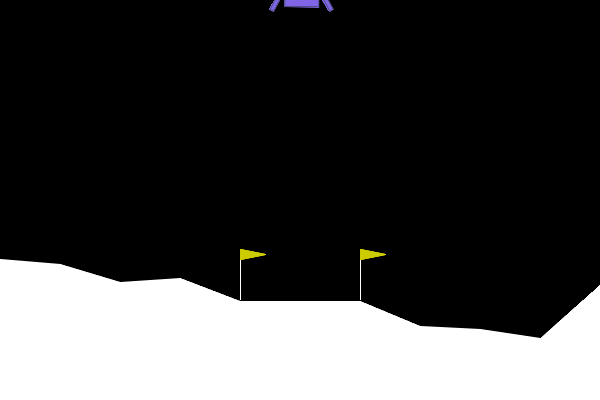

In [9]:
import gymnasium as gym
import imageio.v2 as imageio
import numpy as np
from IPython.display import Image, HTML

def record_video(agent, env_name='LunarLander-v3', episodes=1, seed=42, fps=30):
    """
    Записує відео роботи агента в середовищі Gymnasium.
    """
    env = gym.make(env_name, render_mode="rgb_array")
    frames = []

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        done = False
        while not done:
            # Отримуємо дію від агента
            action = agent.act(state, eps=0.0)  # без epsilon → детерміновано
            state, reward, terminated, truncated, info = env.step(action)
            frames.append(env.render())
            done = terminated or truncated

    env.close()

    # Збереження GIF
    gif_path = "/tmp/agent_lunarlander.gif"
    imageio.mimsave(gif_path, frames, fps=fps, loop=0)

    # Відображення у ноутбуці (циклічно)
    with open(gif_path, "rb") as f:
        data = f.read()
    import base64
    data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
    return HTML(f'<img src="{data_url}" alt="Agent Demo" loop autoplay>')

# --- Виклик ---
display(record_video(agent))

# Завдання

- Реалізуйте алгоритм `Double DQN (DDQN)`
- Реалізуйте `Dueling Deep Q-Networks (Dueling DQN)`
- Навчіть агента
- Порівняйте їхню ефективність для DQN, DDQN та Dueling DQN
- Продемонструйте поведінку навченого агента для різних алгоритмів.
- Зробіть власні висновки та спостереження.

У якості прикладу використовуйте це джерело: https://www.kaggle.com/code/auxeno/dqn-on-lunar-lander-rl